In [152]:
import pyarrow
import pandas as pd
import polars as pl
import numpy as np
import sweetviz as sv
from collections import Counter
import pyarrow.parquet as pq
import numpy as np
import os
import re

In [3]:
debug=False

In [4]:
# Assuming the columns in the dataset are in the order as follows, based on standard Freddie Mac file format
column_names = ["FICO", "FIRST_PAYMENT_DATE","FIRST_TIME_HOMEBUYER_FLAG","MATURITY_DATE","MSA","MI_PERCENTAGE","N_UNITS","OCCUPANCY_STATUS","CLTV","DTI","UPB","LTV","ORIGINAL_INTEREST_RATE","CHANNEL","PPM_FLAG","AMORTIZATION_TYPE","PROPERTY_STATE",'PROPERTY_TYPE','POSTAL_CODE','LOAN_SEQUENCE_NUMBER',"LOAN_PURPOSE","ORIGINAL_LOAN_TERM","N_BORROWERS","SELLER_NAME","SERVICER_NAME","SUPER_CONFORMING_FLAG","PRE_RELIEF_REFINANCE_LOAN_SEQUENCE_NUMBER","PROGRAM_INDICATOR","RELIEF_REFINANCE_INDICATOR","PROPERTY_VALUATION_METHOD","IO_INDICATOR","MI_CANCELLATION_INDICATOR"]

In [5]:
from datetime import datetime
def get_now():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(current_time)

In [7]:
def load_data(file_path, column_names):
    df = pd.read_csv(file_path, delimiter='|', names=column_names, header=None)
    return df

### From the paper

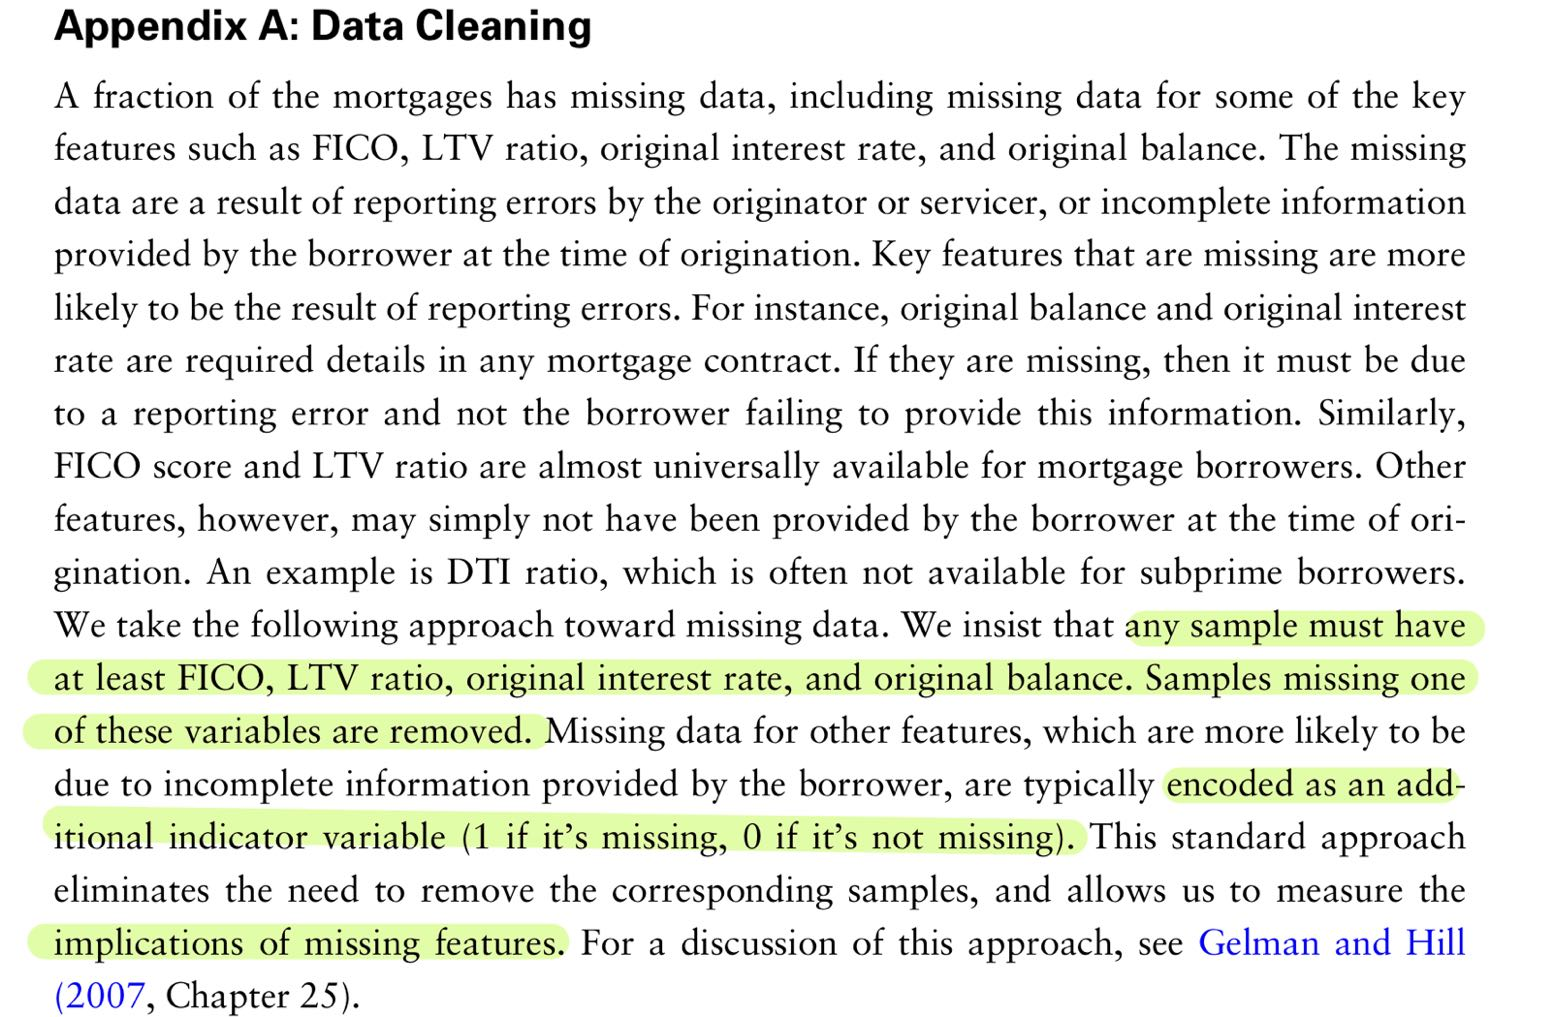

## Drop rows with missing data of certain features

### FICO

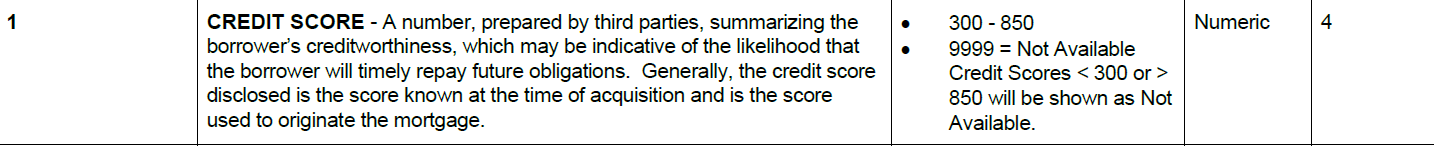

In [10]:
df['FICO'].describe()

count    298579.000000
mean        729.565271
std         271.507135
min         300.000000
25%         680.000000
50%         727.000000
75%         771.000000
max        9999.000000
Name: FICO, dtype: float64

In [11]:
## Number of not available
df['FICO'].value_counts()[9999]

244

### CLTV

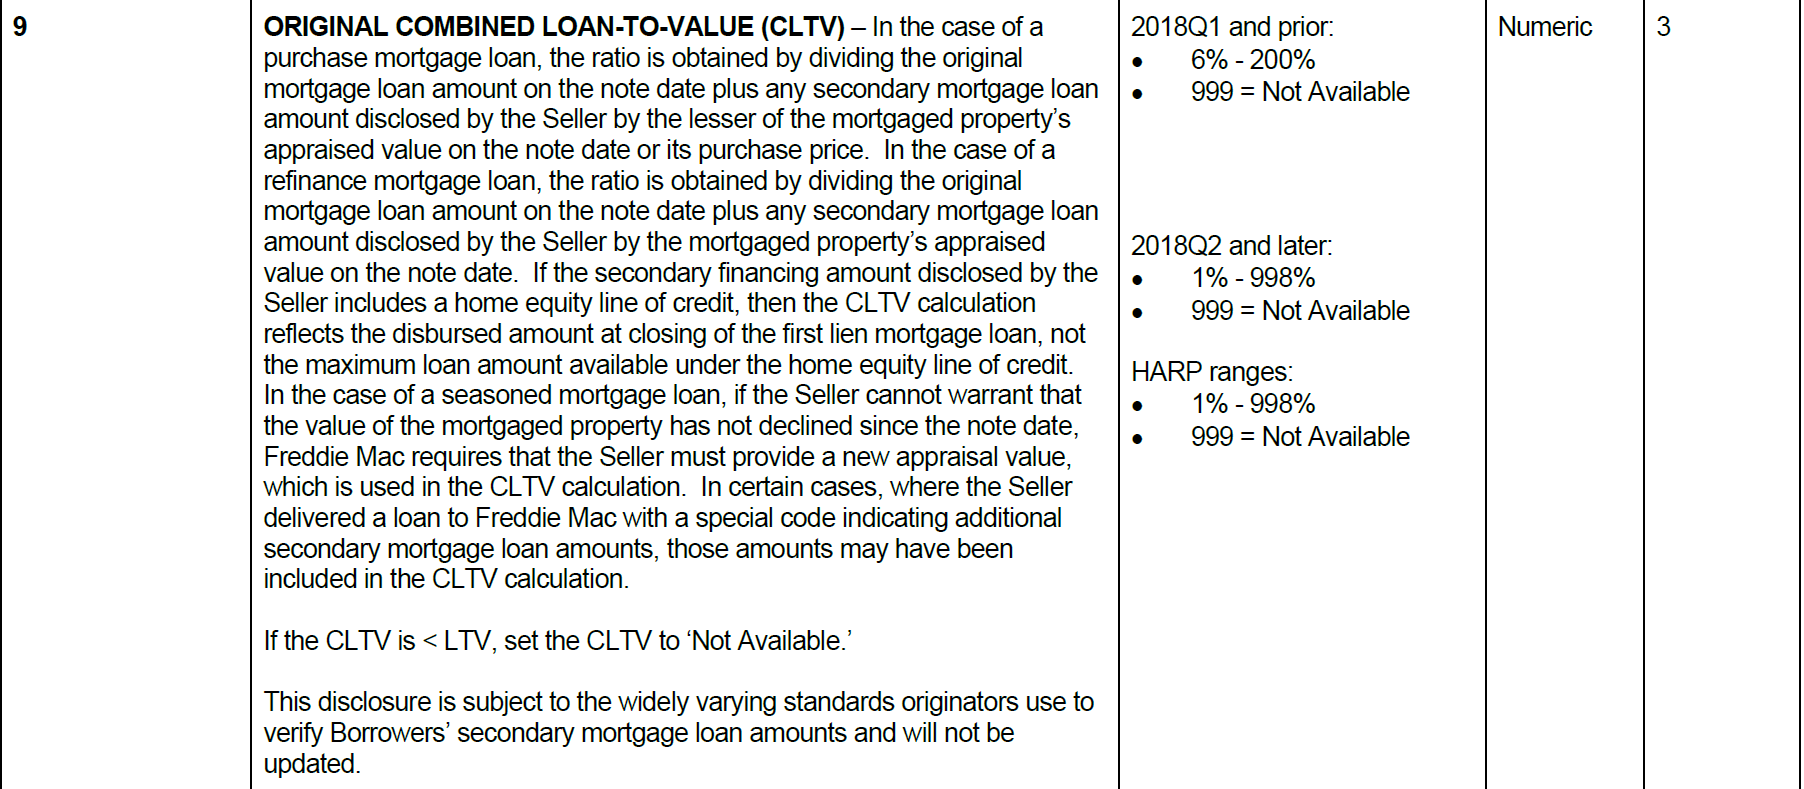

In [12]:
df['CLTV'].describe()

count    298579.000000
mean         71.443872
std          21.191268
min           6.000000
25%          60.000000
50%          77.000000
75%          80.000000
max         999.000000
Name: CLTV, dtype: float64

In [13]:
## Number of not available
df['CLTV'].value_counts()[999]

33

### LTV

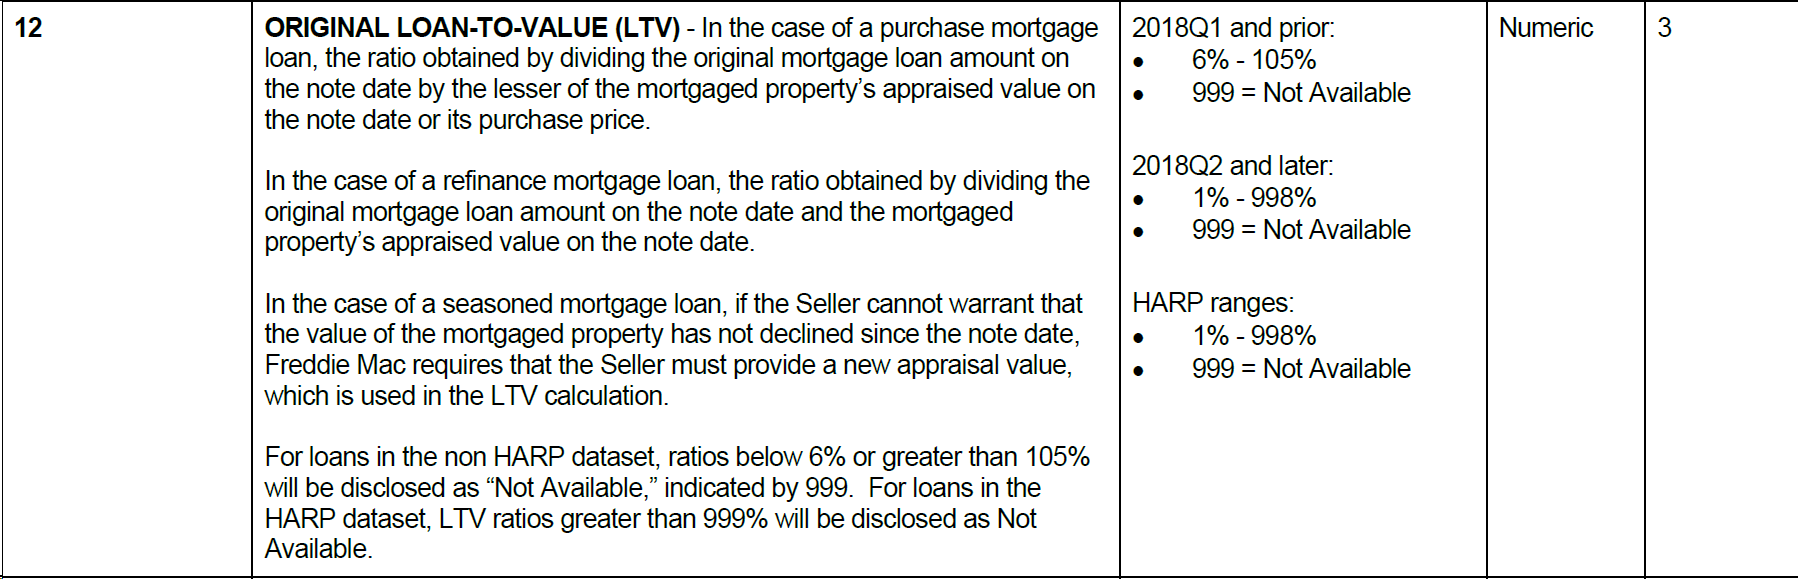

In [14]:
df['LTV'].describe()

count    298579.000000
mean         69.424394
std          20.119087
min           6.000000
25%          60.000000
50%          76.000000
75%          80.000000
max         999.000000
Name: LTV, dtype: float64

In [15]:
df['LTV'].value_counts()[999]

33

### Original interest rate

In [16]:
df['ORIGINAL_INTEREST_RATE'].describe()

count    298579.000000
mean          6.222486
std           0.344443
min           3.500000
25%           6.000000
50%           6.250000
75%           6.375000
max          10.650000
Name: ORIGINAL_INTEREST_RATE, dtype: float64

### MI_PERCENTAGE

With very few missing data so just drop these rows.

In [17]:
df['MI_PERCENTAGE'].value_counts()[999]

1

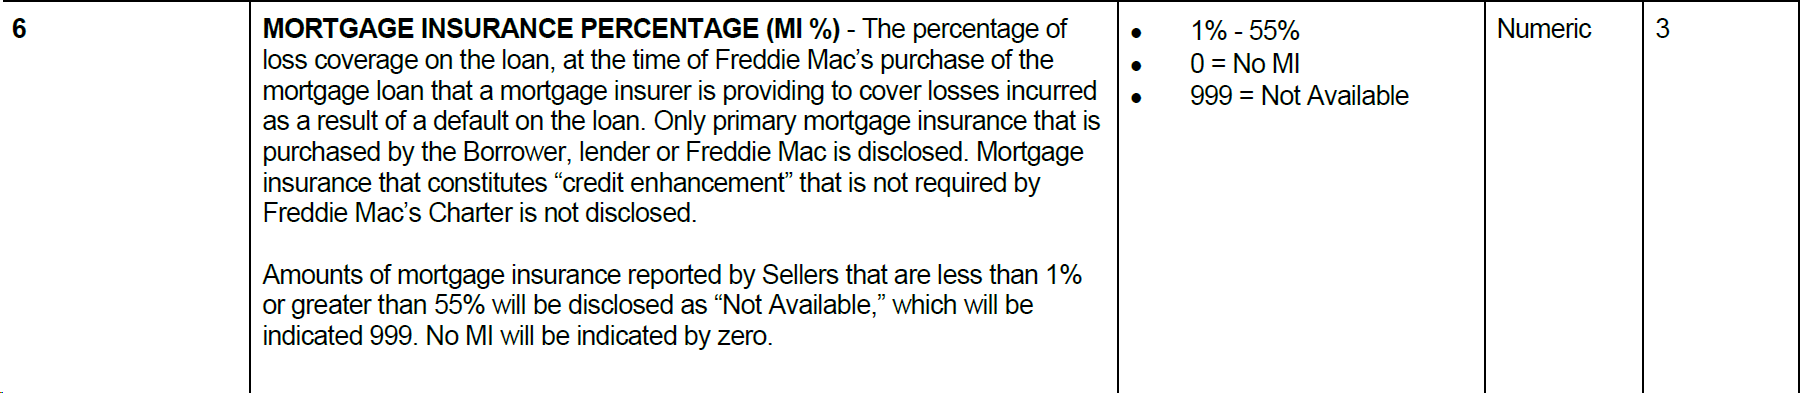

In [18]:
# Rule out the data without FICO, LTV
def Clean_Key_Features(df):
    df = df[df['FICO'] != 9999]
    df = df[df['CLTV'] != 999]
    df = df[df['LTV'] != 999]
    df = df[df['MI_PERCENTAGE'] != 999]
    df = df[df['OCCUPANCY_STATUS'] != '9']
    df = df[df['CHANNEL'] != '9']
    df = df[df['PROPERTY_TYPE'] != '99']
    df = df[df['LOAN_PURPOSE'] != '9']
    return df

## Drop unneccessary features

In [19]:
def drop_features(df):
    df = df.drop('AMORTIZATION_TYPE', axis=1)
    df = df.drop('SELLER_NAME', axis=1)
    df = df.drop('SERVICER_NAME', axis=1)
    df = df.drop(['SUPER_CONFORMING_FLAG',"PRE_RELIEF_REFINANCE_LOAN_SEQUENCE_NUMBER","PROGRAM_INDICATOR","RELIEF_REFINANCE_INDICATOR","PROPERTY_VALUATION_METHOD","IO_INDICATOR","MI_CANCELLATION_INDICATOR"], axis=1)
    return df

## Make Catagorical Features Dummy

### FIRST_TIME_HOMEBUYER_FLAG

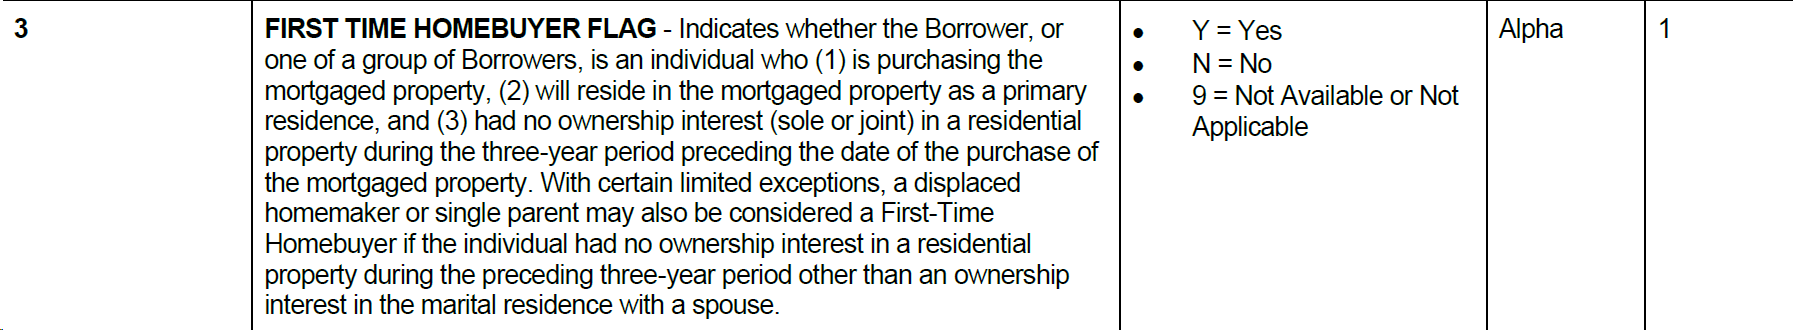

In [20]:
df['FIRST_TIME_HOMEBUYER_FLAG'].value_counts()

FIRST_TIME_HOMEBUYER_FLAG
N    270225
Y     28280
9        74
Name: count, dtype: int64

In [21]:
def dummy_first_time_homebuyer_flag(df):
    dummies = pd.get_dummies(df['FIRST_TIME_HOMEBUYER_FLAG'])
    if 'Y' in dummies.columns:
        dummies = dummies.drop(columns=['Y'])
    # print(dummies)
    dummies.columns = ['FIRST_TIME_HOMEBUYER_' + col for col in dummies.columns]
    if 'FIRST_TIME_HOMEBUYER_9' in dummies.columns:
        dummies.rename(columns={'FIRST_TIME_HOMEBUYER_9': 'FIRST_TIME_HOMEBUYER_MISSING'}, inplace=True)
    result_df = pd.concat([df, dummies], axis=1).drop('FIRST_TIME_HOMEBUYER_FLAG', axis=1)
    return result_df

### Occupancy status

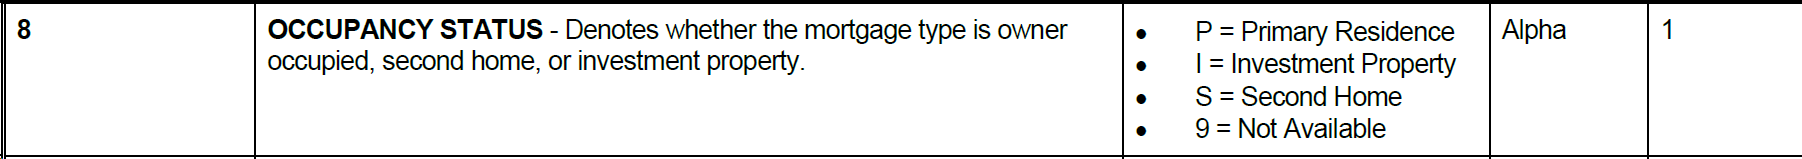

In [22]:
df["OCCUPANCY_STATUS"].value_counts()

OCCUPANCY_STATUS
P    271992
S     14642
I     11945
Name: count, dtype: int64

In [23]:
def dummy_occupancy_status(df):
    dummies = pd.get_dummies(df['OCCUPANCY_STATUS'])
    if 'P' in dummies.columns:
        dummies = dummies.drop(columns=['P'])
    # print(dummies)
    dummies.columns = ['OCCUPANCY_STATUS_' + col for col in dummies.columns]
    result_df = pd.concat([df, dummies], axis=1).drop('OCCUPANCY_STATUS', axis=1)
    return result_df

### CHANNEL

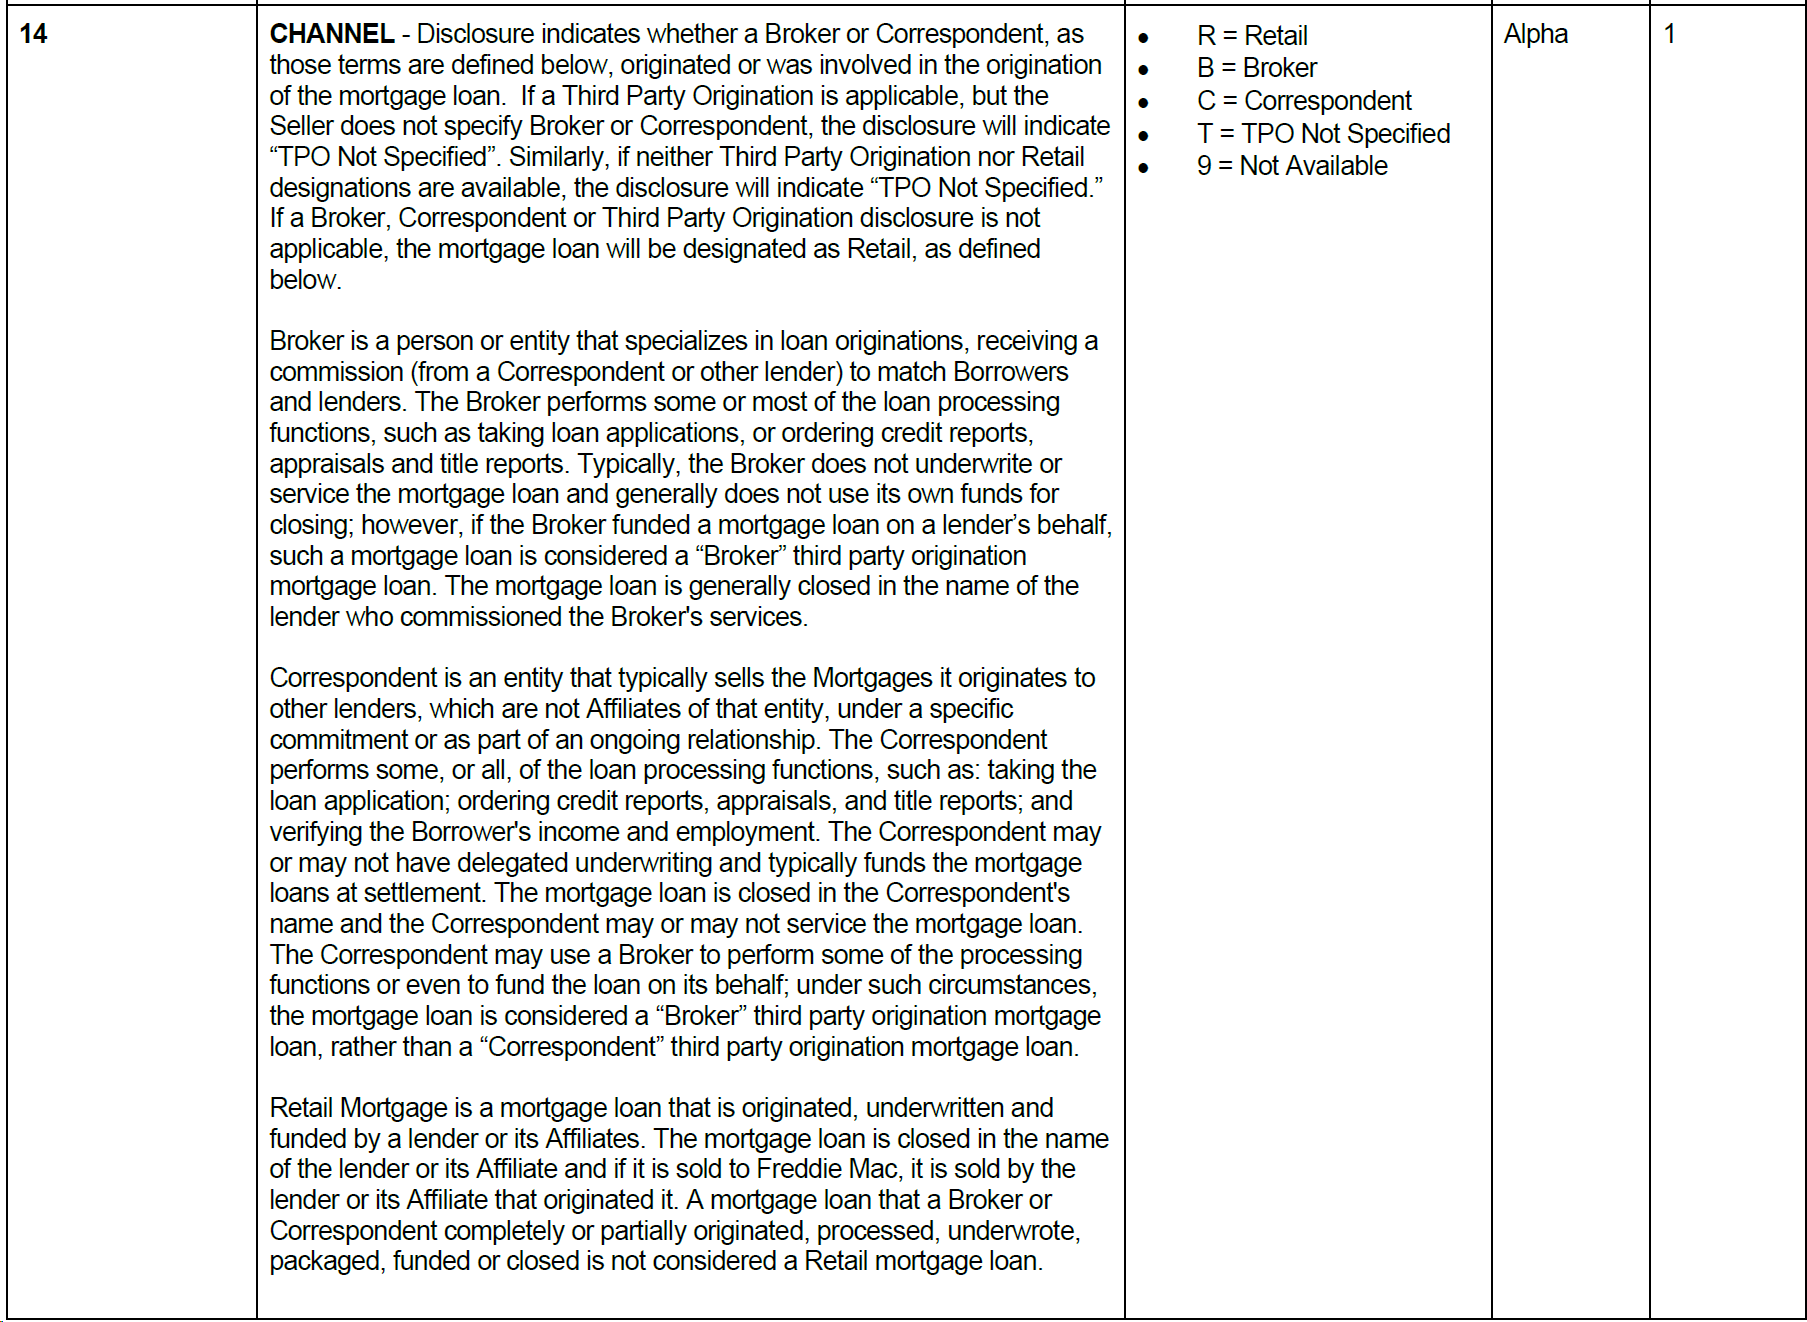

In [24]:
df["CHANNEL"].value_counts()

CHANNEL
T    175948
R    122292
C       228
B       111
Name: count, dtype: int64

In [25]:
def dummy_channel(df):
    dummies = pd.get_dummies(df['CHANNEL'])
    if 'R' in dummies.columns:
        dummies = dummies.drop(columns=['R'])
    # print(dummies)
    dummies.columns = ['CHANNEL_' + col for col in dummies.columns]
    result_df = pd.concat([df, dummies], axis=1).drop('CHANNEL', axis=1)
    return result_df

### Property State

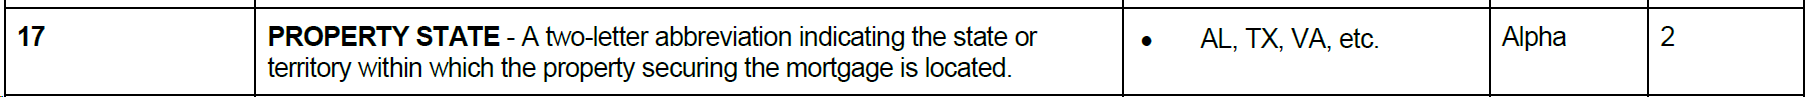

In [26]:
def dummy_property_state(df):
    dummies = pd.get_dummies(df['PROPERTY_STATE'])
    if 'CA' in dummies.columns:
        dummies = dummies.drop(columns=['CA'])
    # print(dummies)
    dummies.columns = ['PROPERTY_STATE_' + col for col in dummies.columns]
    result_df = pd.concat([df, dummies], axis=1).drop('PROPERTY_STATE', axis=1)
    return result_df

### PPM_FLAG

In [27]:
def dummy_ppm_flag(df):
    PPM_FLAG = (df['PPM_FLAG']=='Y')
    result_df = df.copy()
    result_df['PPM_FLAG'] = PPM_FLAG
    return result_df

### Property Type

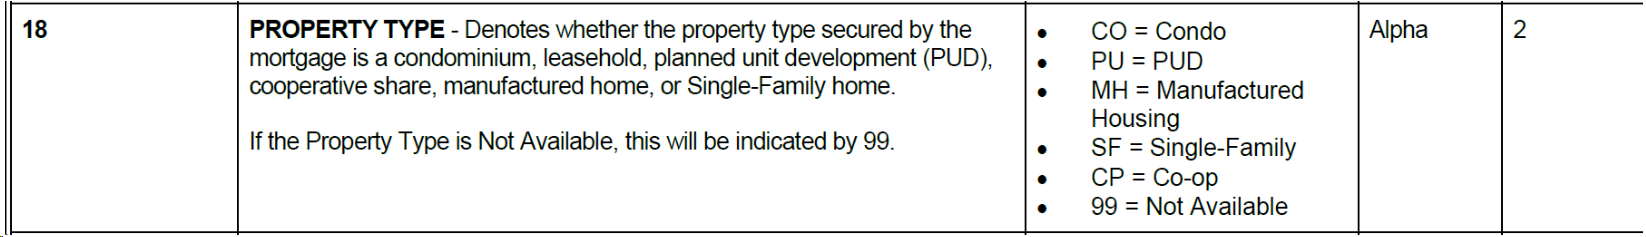

In [28]:
def dummy_property_type(df):
    dummies = pd.get_dummies(df['PROPERTY_TYPE'])
    if 'SF' in dummies.columns:
        dummies = dummies.drop(columns=['SF'])
    # print(dummies)
    dummies.columns = ['PROPERTY_TYPE_' + col for col in dummies.columns]
    result_df = pd.concat([df, dummies], axis=1).drop('PROPERTY_TYPE', axis=1)
    return result_df

### Loan Purpose

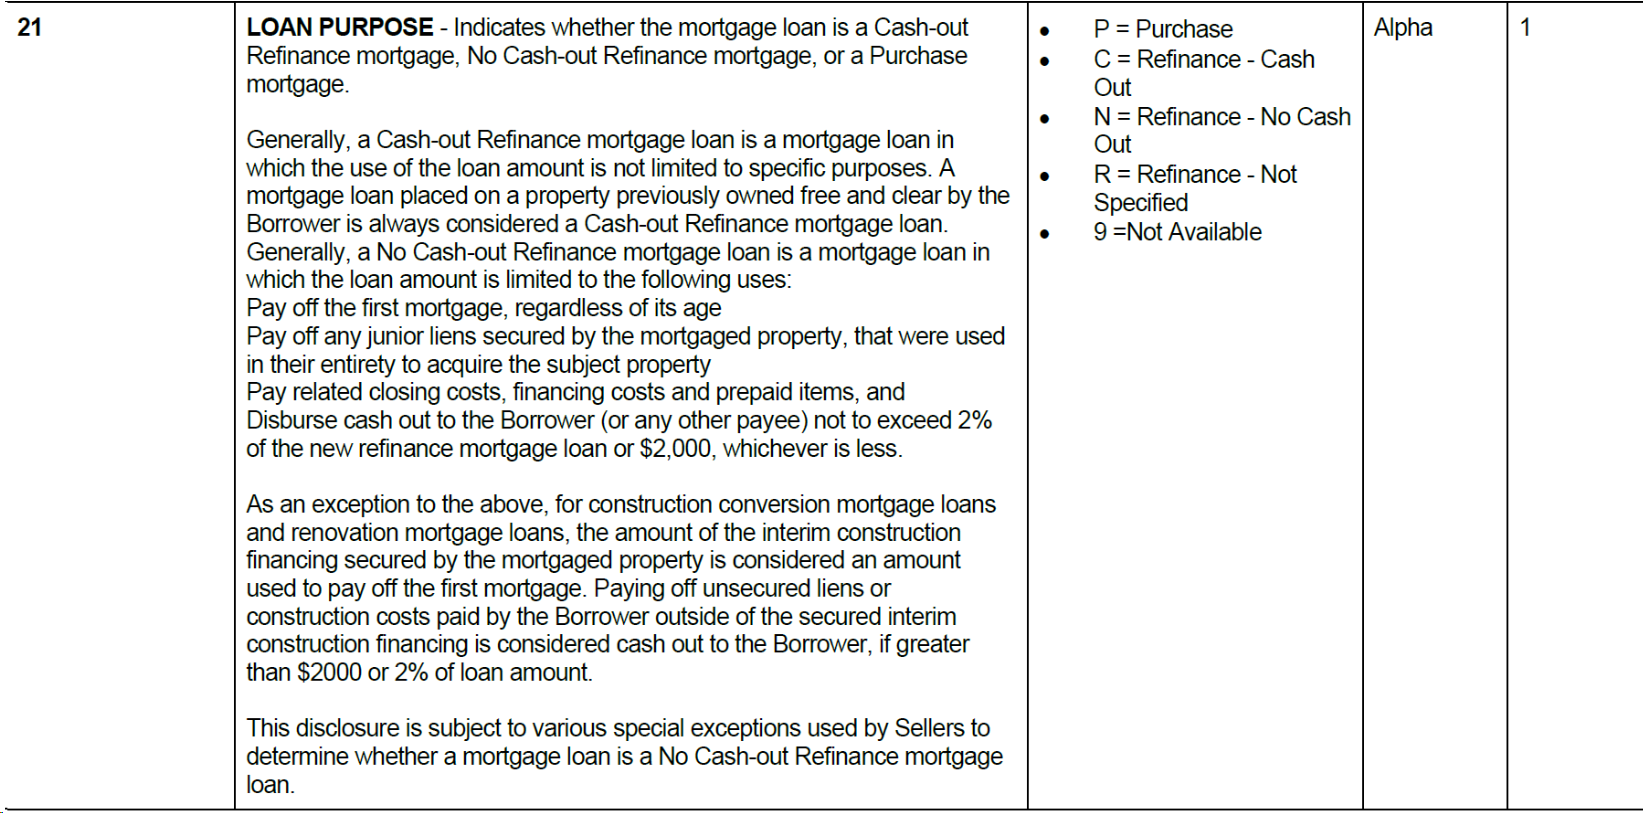

In [29]:
def dummy_loan_purpose(df):
    dummies = pd.get_dummies(df['LOAN_PURPOSE'])
    if 'P' in dummies.columns:
        dummies = dummies.drop(columns=['P'])
    if 'R' in dummies.columns:
        dummies = dummies.drop(columns=['R'])
    # print(dummies)
    dummies.columns = ['LOAN_PURPOSE_' + col for col in dummies.columns]
    result_df = pd.concat([df, dummies], axis=1).drop('LOAN_PURPOSE', axis=1)
    return result_df

## Missing Data Indicators

### MSA

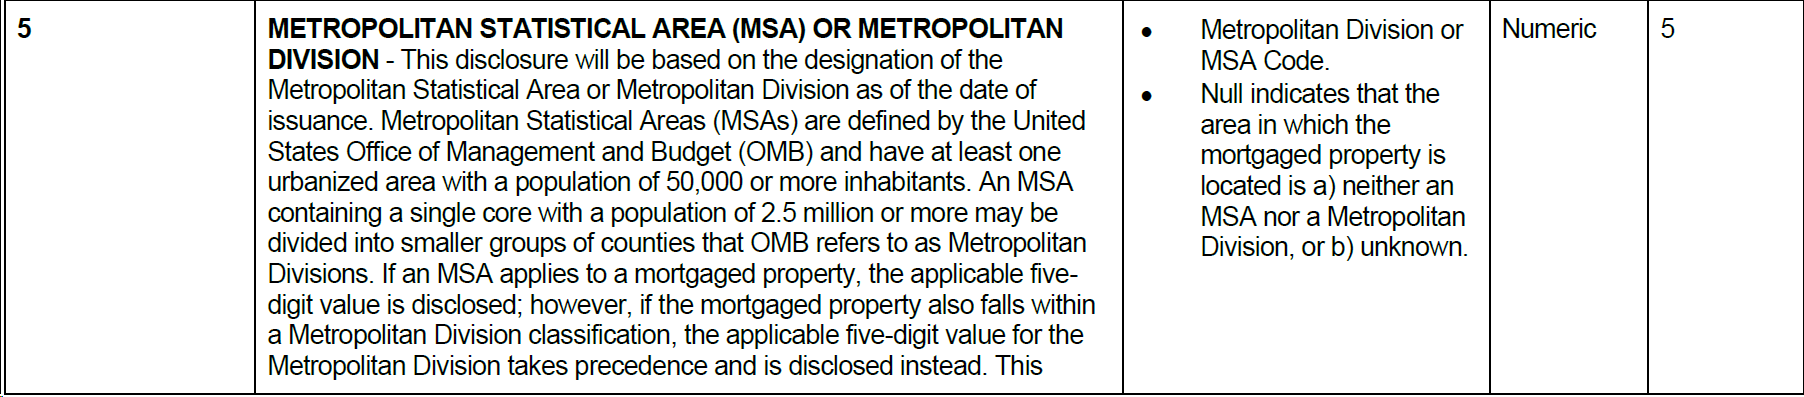

In [30]:
def missing_indicator_MSA(df):
    df['MSA_MISSING'] = df['MSA'].isnull()
    df = df.drop('MSA', axis=1)
    return df

### N_UNITS

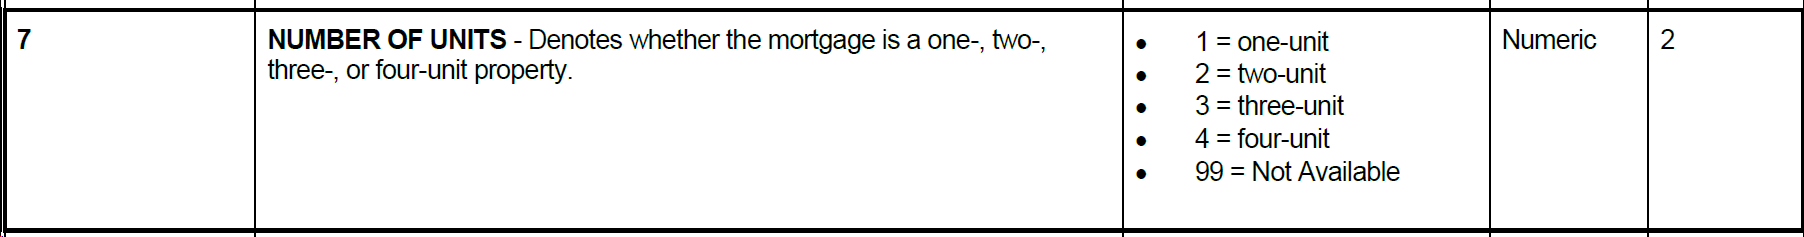

In [31]:
df['N_UNITS'].describe()

count    298579.000000
mean          1.029004
std           0.279763
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          99.000000
Name: N_UNITS, dtype: float64

In [32]:
df['N_UNITS'].value_counts()

N_UNITS
1     292105
2       5022
3        813
4        638
99         1
Name: count, dtype: int64

In [33]:
# Fill the missing data with mode and add an indicator
def missing_indicator_N_UNITS(df):
    result_df = df.copy()
    result_df['N_UNITS_MISSING'] = (result_df['N_UNITS']==99)
    #print(df[df['N_UNITS_MISSING']==True])
    result_df['N_UNITS'] = result_df['N_UNITS'].replace(99,df['N_UNITS'].mode()[0])
    #print(df[df['N_UNITS_MISSING']==True])
    return result_df

### DTI

In [34]:
df['DTI'].describe()

count    298579.000000
mean         62.856118
std         158.170308
min           1.000000
25%          28.000000
50%          37.000000
75%          46.000000
max         999.000000
Name: DTI, dtype: float64

In [35]:
df['DTI'].value_counts()[999]

8240

In [36]:
# Fill the missing data with mode and add an indicator
def missing_indicator_DTI(df):
    result_df = df.copy()
    result_df['DTI_MISSING'] = (result_df['DTI']==999)
    #print(df[df['N_UNITS_MISSING']==True])
    result_df['DTI'] = result_df['DTI'].replace(999,df['DTI'].median())
    #print(df[df['N_UNITS_MISSING']==True])
    return result_df

### N_BORROWERS

In [37]:
df['N_BORROWERS'].value_counts()

N_BORROWERS
2     165426
1     133041
99       112
Name: count, dtype: int64

In [38]:
def missing_indicator_n_borrowers(df):
    result_df = df.copy()
    result_df['N_BORROWERS_MISSING'] = (result_df['N_BORROWERS']==99)
    result_df['N_BORROWERS'] = (result_df['N_BORROWERS']>=2)
    return result_df

# Process the data

In [39]:
df = load_data(file_path,column_names)

In [40]:
df_1 = Clean_Key_Features(df)

In [41]:
df_2 = dummy_first_time_homebuyer_flag(df_1)

In [42]:
df_3 = missing_indicator_MSA(df_2)

In [43]:
df_4 = missing_indicator_N_UNITS(df_3)

In [44]:
df_5 = dummy_occupancy_status(df_4)

In [45]:
df_6 = missing_indicator_DTI(df_5)

In [46]:
df_7 = dummy_channel(df_6)

In [47]:
df_8 = drop_features(df_7)

In [48]:
df_9 = dummy_ppm_flag(df_8)

In [49]:
df_10 = dummy_property_state(df_9)

In [50]:
df_11 = dummy_property_type(df_10)

In [51]:
df_12 = dummy_loan_purpose(df_11)

In [52]:
df_13 = missing_indicator_n_borrowers(df_12)

In [57]:
def process_historical_data(file_path, column_names):
    df = load_data(file_path,column_names)
    df_1 = Clean_Key_Features(df)
    df_2 = dummy_first_time_homebuyer_flag(df_1)
    df_3 = missing_indicator_MSA(df_2)
    df_4 = missing_indicator_N_UNITS(df_3)
    df_5 = dummy_occupancy_status(df_4)
    df_6 = missing_indicator_DTI(df_5)
    df_7 = dummy_channel(df_6)
    df_8 = drop_features(df_7)
    df_9 = dummy_ppm_flag(df_8)
    df_10 = dummy_property_state(df_9)
    df_11 = dummy_property_type(df_10)
    df_12 = dummy_loan_purpose(df_11)
    df_13 = missing_indicator_n_borrowers(df_12)
    return df_13

In [171]:
def combine_with_target(df, time_file_path):
    table = pq.read_table(time_file_path)
    df_from_table = table.to_pandas()
    merged_df = pd.merge(df, df_from_table[['LOAN_SEQUENCE_NUMBER','TARGET','COUNT']], on='LOAN_SEQUENCE_NUMBER', how='inner')
    merged_df.rename(columns={'TARGET': 'PREPAID', 'COUNT': 'PREPAYMENT_TIME'}, inplace=True)
    return merged_df

In [153]:
def extract_date_pattern(filename):
    # Regular expression to find patterns like 2006Q1
    match = re.search(r'\d{4}Q[1-4]', filename)
    if match:
        return match.group(0)  # Return the matched pattern
    return None

def find_corresponding_file(source_filename, target_directory):
    # Extract the date pattern from the source filename
    date_pattern = extract_date_pattern(source_filename)
    if date_pattern:
        # Construct the target file pattern to look for
        target_pattern = f"hist_data_time_{date_pattern}.parquet"
        
        # Search through all files in the target directory
        for filename in os.listdir(target_directory):
            if filename == target_pattern:
                return os.path.join(target_directory, filename)
    
    return None

In [179]:
def process_all_files(historical_path, historical_time_path,column_names):
    results = pd.DataFrame()
    for filename in os.listdir(historical_path):
        file_path = os.path.join(historical_path, filename)
        df = process_historical_data(file_path, column_names)
        time_file_path = find_corresponding_file(filename, historical_time_path)
        merged_df = combine_with_target(df, time_file_path)
        results = pd.concat([results,merged_df])
    return results

In [182]:
historical_path = 'C:\Study\Baruch\MTH9877\HW2\Data\historical_data'

In [183]:
historical_time_path = 'C:\Study\Baruch\MTH9877\HW2\Data\processed_historical_data_time'

In [184]:
result = process_all_files(historical_path, historical_time_path, column_names)

C:\Users\ftx20\AppData\Local\Temp\ipykernel_299344\168526546.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='|', names=column_names, header=None)
C:\Users\ftx20\AppData\Local\Temp\ipykernel_299344\168526546.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='|', names=column_names, header=None)
C:\Users\ftx20\AppData\Local\Temp\ipykernel_299344\168526546.py:2: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='|', names=column_names, header=None)
C:\Users\ftx20\AppData\Local\Temp\ipykernel_299344\168526546.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='|', names=column_names, header=None)
C:\Users\f

In [188]:
result.to_csv('Clean_Data.csv')

In [192]:
result.columns

Index(['FICO', 'FIRST_PAYMENT_DATE', 'MATURITY_DATE', 'MI_PERCENTAGE',
       'N_UNITS', 'CLTV', 'DTI', 'UPB', 'LTV', 'ORIGINAL_INTEREST_RATE',
       'PPM_FLAG', 'POSTAL_CODE', 'LOAN_SEQUENCE_NUMBER', 'ORIGINAL_LOAN_TERM',
       'N_BORROWERS', 'FIRST_TIME_HOMEBUYER_MISSING', 'FIRST_TIME_HOMEBUYER_N',
       'MSA_MISSING', 'N_UNITS_MISSING', 'OCCUPANCY_STATUS_I',
       'OCCUPANCY_STATUS_S', 'DTI_MISSING', 'CHANNEL_B', 'CHANNEL_C',
       'CHANNEL_T', 'PROPERTY_STATE_AK', 'PROPERTY_STATE_AL',
       'PROPERTY_STATE_AR', 'PROPERTY_STATE_AZ', 'PROPERTY_STATE_CO',
       'PROPERTY_STATE_CT', 'PROPERTY_STATE_DC', 'PROPERTY_STATE_DE',
       'PROPERTY_STATE_FL', 'PROPERTY_STATE_GA', 'PROPERTY_STATE_GU',
       'PROPERTY_STATE_HI', 'PROPERTY_STATE_IA', 'PROPERTY_STATE_ID',
       'PROPERTY_STATE_IL', 'PROPERTY_STATE_IN', 'PROPERTY_STATE_KS',
       'PROPERTY_STATE_KY', 'PROPERTY_STATE_LA', 'PROPERTY_STATE_MA',
       'PROPERTY_STATE_MD', 'PROPERTY_STATE_ME', 'PROPERTY_STATE_MI',
       'PRO